# Anomaly Detection Notebook 
# Overview
This notebook implements multiple anomaly detection algorithms on the engineered features.
Algorithms to Implement:
1. Statistical Methods: Z-score, IQR, Mahalanobis Distance
2. Machine Learning: Isolation Forest, Local Outlier Factor (LOF), One-Class SVM
3. Ensemble Methods: Combining multiple detectors
4. Customer Segmentation: Different models for different customer segments
5. Evaluation: Performance metrics and business impact analysis

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Anomaly detection algorithms
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN

# Feature processing and evaluation
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (roc_auc_score, precision_recall_curve, auc,
                           confusion_matrix, classification_report, 
                           roc_curve, f1_score, precision_score, recall_score)

# Statistical methods
from scipy import stats
from scipy.spatial.distance import mahalanobis
from scipy.stats import zscore

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set visualization styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# For better display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# Load engineered features
try:
    # Try scaled features first
    df_features = pd.read_csv('../data/outputs/customer_features_scaled1.csv')
    print(f"✅ Scaled features loaded! Shape: {df_features.shape}")
except FileNotFoundError:
    try:
        # Fallback to original features
        df_features = pd.read_csv('../data/outputs/customer_features_original.csv')
        print(f"✅ Original features loaded! Shape: {df_features.shape}")
    except FileNotFoundError:
        print("❌ No feature files found! Run feature engineering notebook first.")
        raise

# Display feature information
print(f"\n📊 Dataset shape: {df_features.shape}")
print(f"Total customers: {len(df_features):,}")
print(f"Total features: {len(df_features.columns)}")

print("\n📋 First 3 rows:")
display(df_features.head(3))

✅ Scaled features loaded! Shape: (3230, 219)

📊 Dataset shape: (3230, 219)
Total customers: 3,230
Total features: 219

📋 First 3 rows:


,Account_Number,Account_Number.1,First_Transaction_Date,Last_Transaction_Date,Preferred_Channel,Preferred_Time_Category,Transaction_Frequency_std,Total_Transaction_Amount_std,Avg_Transaction_Amount_x_std,Std_Transaction_Amount_x_std,Min_Transaction_Amount_x_std,Max_Transaction_Amount_x_std,Unique_Channels_Used_std,Unique_Branches_Used_std,Debit_Transaction_Count_std,Customer_Lifetime_Days_std,Recency_Days_std,Avg_Daily_Spend_std,Transactions_Per_Day_std,Amount_Coefficient_Variation_std,Debit_Ratio_x_std,Channel_Diversity_Score_std,Branch_Diversity_Score_std,Channel_Entropy_std,Channel_HHI_std,Top2_Channel_Concentration_std,Channel_Deviation_Rate_std,Avg_Distance_From_Home_km_std,Max_Distance_From_Home_km_std,Std_Distance_From_Home_km_std,Location_Anomaly_Count_std,Unique_Branches_Visited_std,Unique_Regions_Visited_std,Total_Transactions_x_std,Location_Anomaly_Rate_std,Geographic_Dispersion_Score_std,Avg_Transaction_Hour_std,Std_Transaction_Hour_std,Mode_Transaction_Hour_std,Weekend_Transaction_Ratio_std,Avg_Time_Between_Txn_Hours_std,Std_Time_Between_Txn_Hours_std,Min_Time_Between_Txn_Hours_std,Max_Time_Between_Txn_Hours_std,Temporal_Consistency_Score_std,Avg_Transaction_Amount_y_std,Std_Transaction_Amount_y_std,Min_Transaction_Amount_y_std,Max_Transaction_Amount_y_std,Median_Transaction_Amount_std,Q1_Transaction_Amount_std,Q3_Transaction_Amount_std,Amount_Skewness_std,Amount_Kurtosis_std,Amount_Range_std,IQR_Amount_std,Amount_CV_std,High_Volatility_Flag_std,High_Skewness_Flag_std,Pct_Small_Transactions_std,Pct_Medium_Transactions_std,Pct_Large_Transactions_std,Pct_Very_Large_Transactions_std,Total_Transactions_y_std,Debit_Count_std,Credit_Count_std,Debit_Ratio_y_std,Total_Debit_Amount_std,Total_Credit_Amount_std,Avg_Debit_Amount_std,Avg_Credit_Amount_std,Credit_Ratio_std,Net_Flow_std,Avg_Net_Flow_Per_Txn_std,Debit_Credit_Ratio_Amount_std,Type_Switch_Count_std,Type_Switch_Rate_std,Transaction_Frequency_minmax,Total_Transaction_Amount_minmax,Avg_Transaction_Amount_x_minmax,Std_Transaction_Amount_x_minmax,Min_Transaction_Amount_x_minmax,Max_Transaction_Amount_x_minmax,Unique_Channels_Used_minmax,Unique_Branches_Used_minmax,Debit_Transaction_Count_minmax,Customer_Lifetime_Days_minmax,Recency_Days_minmax,Avg_Daily_Spend_minmax,Transactions_Per_Day_minmax,Amount_Coefficient_Variation_minmax,Debit_Ratio_x_minmax,Channel_Diversity_Score_minmax,Branch_Diversity_Score_minmax,Channel_Entropy_minmax,Channel_HHI_minmax,Top2_Channel_Concentration_minmax,Channel_Deviation_Rate_minmax,Avg_Distance_From_Home_km_minmax,Max_Distance_From_Home_km_minmax,Std_Distance_From_Home_km_minmax,Location_Anomaly_Count_minmax,Unique_Branches_Visited_minmax,Unique_Regions_Visited_minmax,Total_Transactions_x_minmax,Location_Anomaly_Rate_minmax,Geographic_Dispersion_Score_minmax,Avg_Transaction_Hour_minmax,Std_Transaction_Hour_minmax,Mode_Transaction_Hour_minmax,Weekend_Transaction_Ratio_minmax,Avg_Time_Between_Txn_Hours_minmax,Std_Time_Between_Txn_Hours_minmax,Min_Time_Between_Txn_Hours_minmax,Max_Time_Between_Txn_Hours_minmax,Temporal_Consistency_Score_minmax,Avg_Transaction_Amount_y_minmax,Std_Transaction_Amount_y_minmax,Min_Transaction_Amount_y_minmax,Max_Transaction_Amount_y_minmax,Median_Transaction_Amount_minmax,Q1_Transaction_Amount_minmax,Q3_Transaction_Amount_minmax,Amount_Skewness_minmax,Amount_Kurtosis_minmax,Amount_Range_minmax,IQR_Amount_minmax,Amount_CV_minmax,High_Volatility_Flag_minmax,High_Skewness_Flag_minmax,Pct_Small_Transactions_minmax,Pct_Medium_Transactions_minmax,Pct_Large_Transactions_minmax,Pct_Very_Large_Transactions_minmax,Total_Transactions_y_minmax,Debit_Count_minmax,Credit_Count_minmax,Debit_Ratio_y_minmax,Total_Debit_Amount_minmax,Total_Credit_Amount_minmax,Avg_Debit_Amount_minmax,Avg_Credit_Amount_minmax,Credit_Ratio_minmax,Net_Flow_minmax,Avg_Net_Flow_Per_Txn_minmax,Debit_Credit_Ratio_Amount_minmax,Type_Switch_Count_minmax,Type_Switch_Rate_minmax,Transaction_Frequency_robust,Total_Transaction_Amount_robust,Avg_Transaction_Am

In [3]:
# Check for Account_Number column
if 'Account_Number' in df_features.columns:
    print(f"✅ Account_Number column found with {df_features['Account_Number'].nunique():,} unique customers")
else:
    # Create synthetic Account_Number if missing
    df_features['Account_Number'] = range(1, len(df_features) + 1)
    print("⚠️ Account_Number column not found. Created synthetic IDs.")

✅ Account_Number column found with 3,230 unique customers


# 2.1 Feature Selection and Preparation
Select and prepare features for anomaly detection.

In [4]:
print("🔄 PREPARING FEATURES FOR ANOMALY DETECTION")
print("="*60)

# Identify feature columns (exclude non-feature columns)
exclude_cols = ['Account_Number', 'First_Transaction_Date', 'Last_Transaction_Date']
feature_cols = [col for col in df_features.columns if col not in exclude_cols]

# Separate numeric and categorical features
numeric_features = df_features[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_features[feature_cols].select_dtypes(exclude=[np.number]).columns.tolist()

print(f"📊 Feature Breakdown:")
print(f"   • Total features: {len(feature_cols)}")
print(f"   • Numeric features: {len(numeric_features)}")
print(f"   • Categorical features: {len(categorical_features)}")
print(f"   • Excluded columns: {len(exclude_cols)}")

# Display top features
print("\n📋 Top 10 Numeric Features:")
for i, feat in enumerate(numeric_features[:10], 1):
    print(f"   {i:2d}. {feat}")

if categorical_features:
    print("\n📋 Categorical Features:")
    for i, feat in enumerate(categorical_features, 1):
        print(f"   {i:2d}. {feat}")

🔄 PREPARING FEATURES FOR ANOMALY DETECTION
📊 Feature Breakdown:
   • Total features: 216
   • Numeric features: 214
   • Categorical features: 2
   • Excluded columns: 3

📋 Top 10 Numeric Features:
    1. Account_Number.1
    2. Transaction_Frequency_std
    3. Total_Transaction_Amount_std
    4. Avg_Transaction_Amount_x_std
    5. Std_Transaction_Amount_x_std
    6. Min_Transaction_Amount_x_std
    7. Max_Transaction_Amount_x_std
    8. Unique_Channels_Used_std
    9. Unique_Branches_Used_std
   10. Debit_Transaction_Count_std

📋 Categorical Features:
    1. Preferred_Channel
    2. Preferred_Time_Category


In [5]:
# Handle categorical features (one-hot encoding if any)
if categorical_features:
    print(f"\n🔤 Encoding {len(categorical_features)} categorical features...")
    df_encoded = pd.get_dummies(df_features, columns=categorical_features, drop_first=True)
    
    # Update feature lists
    all_features = [col for col in df_encoded.columns if col not in exclude_cols]
    numeric_features = df_encoded[all_features].select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"   → After encoding: {len(numeric_features)} numeric features")
    X = df_encoded[numeric_features].values
else:
    print("\n✅ No categorical features to encode")
    X = df_features[numeric_features].values

# Store customer IDs
customer_ids = df_features['Account_Number'].values

print(f"\n✅ Final feature matrix shape: {X.shape}")
print(f"   • Samples: {X.shape[0]:,}")
print(f"   • Features: {X.shape[1]}")


🔤 Encoding 2 categorical features...
   → After encoding: 214 numeric features

✅ Final feature matrix shape: (3893, 214)
   • Samples: 3,893
   • Features: 214


In [6]:
# Check for missing values
missing_values = np.isnan(X).sum()
if missing_values > 0:
    print(f"⚠️ Found {missing_values:,} missing values. Imputing with median...")
    
    # Impute missing values with column median
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    X = imputer.fit_transform(X)
    print(f"✅ Missing values imputed")
else:
    print("✅ No missing values found")

✅ No missing values found


In [7]:
# Feature scaling (important for distance-based algorithms)
print("\n📏 Scaling features...")

# Create different scaling options
scaler_standard = StandardScaler()
scaler_robust = RobustScaler()

X_standard = scaler_standard.fit_transform(X)
X_robust = scaler_robust.fit_transform(X)

print("✅ Features scaled with:")
print(f"   • StandardScaler (mean=0, std=1)")
print(f"   • RobustScaler (median=0, IQR=1)")

# Use robust scaling as default (more resistant to outliers)
X_scaled = X_robust.copy()

# Save feature names for reference
feature_names = numeric_features


📏 Scaling features...
✅ Features scaled with:
   • StandardScaler (mean=0, std=1)
   • RobustScaler (median=0, IQR=1)


# 3.1 PCA for Visualization
Reduce dimensions to visualize data structure.


In [8]:
print("\n🎨 DIMENSIONALITY REDUCTION FOR VISUALIZATION")
print("="*60)

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"✅ PCA applied. Explained variance:")
print(f"   • PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"   • PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"   • Total: {pca.explained_variance_ratio_.sum():.2%}")

# Create DataFrame for visualization
df_viz = pd.DataFrame({
    'Account_Number': customer_ids,
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1]
})

# Add some original features for coloring
if 'Avg_Transaction_Amount' in df_features.columns:
    df_viz['Avg_Transaction_Amount'] = df_features['Avg_Transaction_Amount'].values
if 'Transaction_Frequency' in df_features.columns:
    df_viz['Transaction_Frequency'] = df_features['Transaction_Frequency'].values

print("\n📊 PCA Visualization Data Sample:")
display(df_viz.head())


🎨 DIMENSIONALITY REDUCTION FOR VISUALIZATION
✅ PCA applied. Explained variance:
   • PC1: 99.95%
   • PC2: 0.04%
   • Total: 99.99%

📊 PCA Visualization Data Sample:


,Account_Number,PC1,PC2
0,2045317750241665,-33468.4122,-143.8431
1,2085819311717140,7522.6959,-215.3659
2,2086053779385715,7306.7656,-210.9260
3,2096079580518340,7266.0082,-193.2843
4,2096849698333690,7265.8200,-143.1420


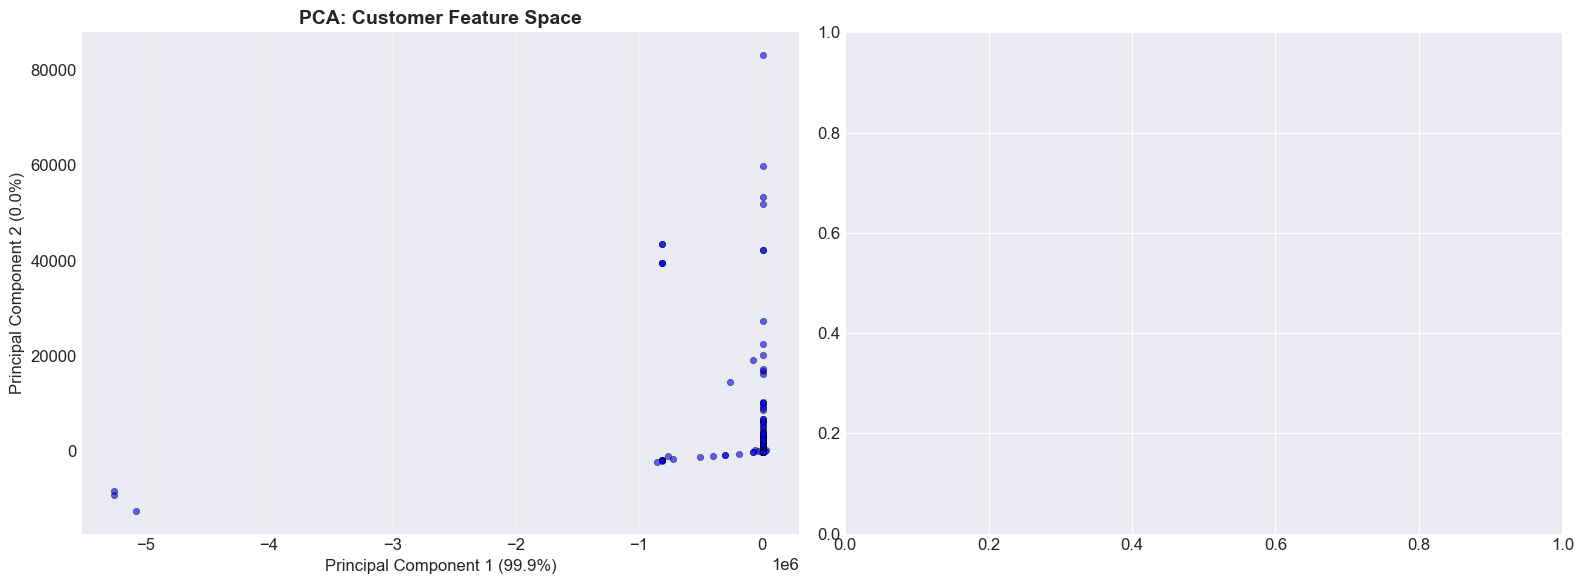

In [9]:
# Visualize PCA results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Basic PCA scatter
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=20, c='blue', edgecolors='k', linewidth=0.5)
axes[0].set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0].set_title('PCA: Customer Feature Space', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Colored by transaction frequency (if available)
if 'Transaction_Frequency' in df_viz.columns:
    scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], 
                              c=df_viz['Transaction_Frequency'], 
                              alpha=0.6, s=20, cmap='viridis',
                              edgecolors='k', linewidth=0.5)
    axes[1].set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%})')
    axes[1].set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%})')
    axes[1].set_title('PCA: Colored by Transaction Frequency', fontsize=14, fontweight='bold')
    plt.colorbar(scatter2, ax=axes[1], label='Transaction Frequency')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4.1 Z-Score Method
Detect anomalies using z-scores (assumes normal distribution).


In [10]:
print("\n📊 STATISTICAL ANOMALY DETECTION: Z-SCORE METHOD")
print("="*60)

def detect_anomalies_zscore(data, threshold=3):
    """
    Detect anomalies using z-score method.
    
    Parameters:
    -----------
    data : numpy array
        Feature matrix (n_samples, n_features)
    threshold : float
        Z-score threshold for anomaly detection
    
    Returns:
    --------
    anomaly_scores : numpy array
        Z-scores for each sample
    anomaly_flags : numpy array
        Binary flags (1=anomaly, 0=normal)
    """
    # Calculate z-scores for each feature
    z_scores = np.abs(zscore(data, axis=0, nan_policy='omit'))
    
    # Take maximum z-score across features for each sample
    max_z_scores = np.nanmax(z_scores, axis=1)
    
    # Flag anomalies where any feature exceeds threshold
    anomaly_flags = (max_z_scores > threshold).astype(int)
    
    return max_z_scores, anomaly_flags

# Apply z-score method
z_threshold = 3
z_scores, z_anomalies = detect_anomalies_zscore(X_scaled, threshold=z_threshold)

print(f"✅ Z-score analysis completed (threshold={z_threshold})")
print(f"   • Anomalies detected: {z_anomalies.sum():,} ({z_anomalies.sum()/len(z_anomalies):.2%})")
print(f"   • Normal samples: {(1 - z_anomalies).sum():,} ({(1 - z_anomalies).sum()/len(z_anomalies):.2%})")

# Analyze anomaly distribution
if z_anomalies.sum() > 0:
    print(f"\n📈 Z-score statistics for anomalies:")
    print(f"   • Min z-score: {z_scores.min():.2f}")
    print(f"   • Max z-score: {z_scores.max():.2f}")
    print(f"   • Mean z-score: {z_scores.mean():.2f}")
    print(f"   • Median z-score: {z_scores[z_anomalies == 1].mean():.2f} (anomalies only)")


📊 STATISTICAL ANOMALY DETECTION: Z-SCORE METHOD
✅ Z-score analysis completed (threshold=3)
   • Anomalies detected: 843 (21.65%)
   • Normal samples: 3,050 (78.35%)

📈 Z-score statistics for anomalies:
   • Min z-score: 0.70
   • Max z-score: 49.68
   • Mean z-score: 2.45
   • Median z-score: 5.41 (anomalies only)


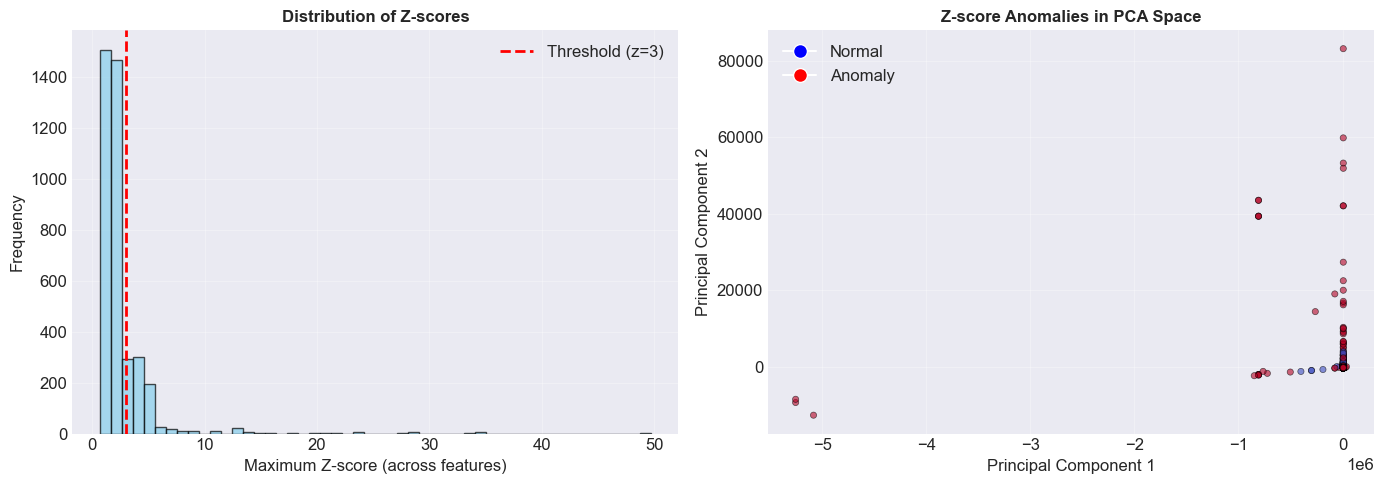

In [11]:
# Visualize z-score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Z-score distribution
axes[0].hist(z_scores, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(z_threshold, color='red', linestyle='--', linewidth=2, 
                label=f'Threshold (z={z_threshold})')
axes[0].set_xlabel('Maximum Z-score (across features)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Z-scores', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Anomaly vs normal in PCA space
scatter = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=z_anomalies, cmap='coolwarm',
                         alpha=0.6, s=20, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel(f'Principal Component 1')
axes[1].set_ylabel(f'Principal Component 2')
axes[1].set_title('Z-score Anomalies in PCA Space', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add legend for anomaly colors
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor='blue', markersize=10, label='Normal'),
                   Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor='red', markersize=10, label='Anomaly')]
axes[1].legend(handles=legend_elements)

plt.tight_layout()
plt.show()

# 4.2 IQR (Interquartile Range) Method
Detect anomalies using IQR method (less sensitive to outliers than z-score).

In [12]:
print("\n📊 STATISTICAL ANOMALY DETECTION: IQR METHOD")
print("="*60)

def detect_anomalies_iqr(data, threshold=1.5):
    """
    Detect anomalies using IQR method.
    
    Parameters:
    -----------
    data : numpy array
        Feature matrix (n_samples, n_features)
    threshold : float
        IQR multiplier threshold (typically 1.5)
    
    Returns:
    --------
    anomaly_scores : numpy array
        Distance from IQR bounds (normalized)
    anomaly_flags : numpy array
        Binary flags (1=anomaly, 0=normal)
    """
    anomaly_flags = np.zeros(data.shape[0])
    anomaly_scores = np.zeros(data.shape[0])
    
    for i in range(data.shape[1]):
        col_data = data[:, i]
        
        # Calculate quartiles
        Q1 = np.percentile(col_data, 25)
        Q3 = np.percentile(col_data, 75)
        IQR = Q3 - Q1
        
        # Calculate bounds
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Find anomalies in this feature
        col_anomalies = (col_data < lower_bound) | (col_data > upper_bound)
        
        # Calculate normalized distance from bounds
        col_scores = np.zeros_like(col_data)
        mask_lower = col_data < lower_bound
        mask_upper = col_data > upper_bound
        
        if np.any(mask_lower):
            col_scores[mask_lower] = (lower_bound - col_data[mask_lower]) / IQR
        if np.any(mask_upper):
            col_scores[mask_upper] = (col_data[mask_upper] - upper_bound) / IQR
        
        # Update global flags and scores
        anomaly_flags = np.logical_or(anomaly_flags, col_anomalies)
        anomaly_scores = np.maximum(anomaly_scores, np.abs(col_scores))
    
    return anomaly_scores.astype(float), anomaly_flags.astype(int)

# Apply IQR method
iqr_threshold = 1.5
iqr_scores, iqr_anomalies = detect_anomalies_iqr(X_scaled, threshold=iqr_threshold)

print(f"✅ IQR analysis completed (threshold={iqr_threshold})")
print(f"   • Anomalies detected: {iqr_anomalies.sum():,} ({iqr_anomalies.sum()/len(iqr_anomalies):.2%})")
print(f"   • Normal samples: {(1 - iqr_anomalies).sum():,} ({(1 - iqr_anomalies).sum()/len(iqr_anomalies):.2%})")


📊 STATISTICAL ANOMALY DETECTION: IQR METHOD
✅ IQR analysis completed (threshold=1.5)
   • Anomalies detected: 3,353 (86.13%)
   • Normal samples: 540 (13.87%)


# 5.1 Isolation Forest
Tree-based algorithm specifically designed for anomaly detection.

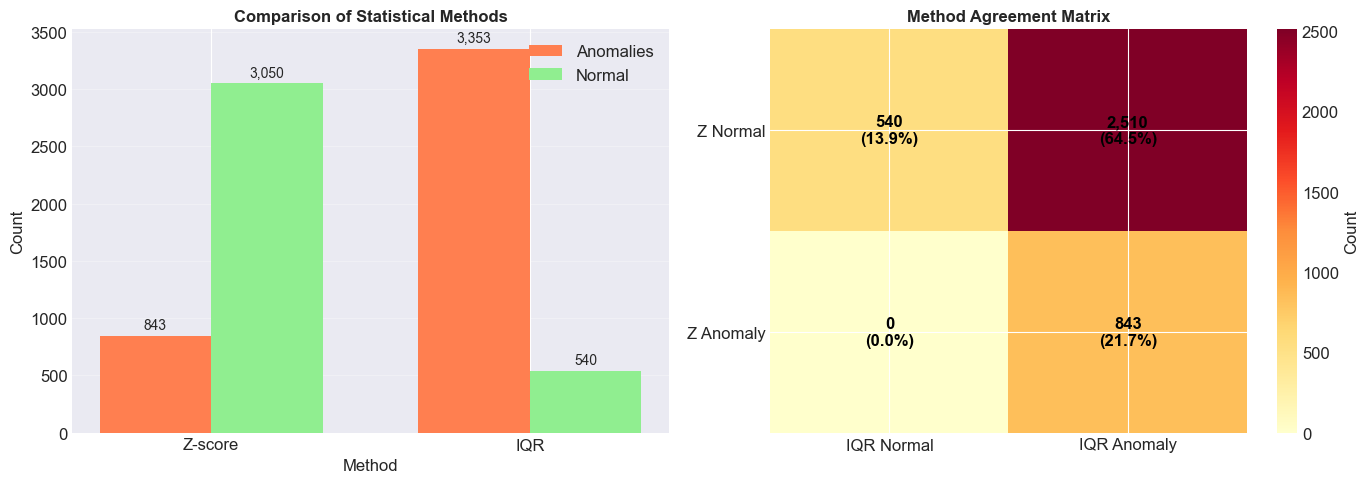


🤝 Method Agreement Analysis:
   • Both methods agree on anomalies: 843.0 customers
   • Agreement rate: 25.14%
   • Disagreement: 2,510.0 customers


In [13]:
# Compare statistical methods
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Comparison of anomaly counts
methods = ['Z-score', 'IQR']
anomaly_counts = [z_anomalies.sum(), iqr_anomalies.sum()]
normal_counts = [len(z_anomalies) - z_anomalies.sum(), len(iqr_anomalies) - iqr_anomalies.sum()]

x = np.arange(len(methods))
width = 0.35

bars1 = axes[0].bar(x - width/2, anomaly_counts, width, label='Anomalies', color='coral')
bars2 = axes[0].bar(x + width/2, normal_counts, width, label='Normal', color='lightgreen')

axes[0].set_xlabel('Method')
axes[0].set_ylabel('Count')
axes[0].set_title('Comparison of Statistical Methods', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2, height + max(anomaly_counts)*0.01,
                    f'{int(height):,}', ha='center', va='bottom', fontsize=10)

# Plot 2: Agreement between methods
agreement_matrix = np.zeros((2, 2))
agreement_matrix[0, 0] = ((z_anomalies == 0) & (iqr_anomalies == 0)).sum()  # Both normal
agreement_matrix[0, 1] = ((z_anomalies == 0) & (iqr_anomalies == 1)).sum()  # Z normal, IQR anomaly
agreement_matrix[1, 0] = ((z_anomalies == 1) & (iqr_anomalies == 0)).sum()  # Z anomaly, IQR normal
agreement_matrix[1, 1] = ((z_anomalies == 1) & (iqr_anomalies == 1)).sum()  # Both anomaly

im = axes[1].imshow(agreement_matrix, cmap='YlOrRd', aspect='auto')
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['IQR Normal', 'IQR Anomaly'])
axes[1].set_yticklabels(['Z Normal', 'Z Anomaly'])
axes[1].set_title('Method Agreement Matrix', fontsize=12, fontweight='bold')

# Add text annotations
for i in range(2):
    for j in range(2):
        text = axes[1].text(j, i, f'{int(agreement_matrix[i, j]):,}\n({agreement_matrix[i, j]/len(z_anomalies):.1%})',
                           ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=axes[1], label='Count')
plt.tight_layout()
plt.show()

# Calculate agreement metrics
both_anomaly = agreement_matrix[1, 1]
either_anomaly = agreement_matrix[0, 1] + agreement_matrix[1, 0] + agreement_matrix[1, 1]
agreement_rate = both_anomaly / either_anomaly if either_anomaly > 0 else 0

print(f"\n🤝 Method Agreement Analysis:")
print(f"   • Both methods agree on anomalies: {both_anomaly:,} customers")
print(f"   • Agreement rate: {agreement_rate:.2%}")
print(f"   • Disagreement: {agreement_matrix[0, 1] + agreement_matrix[1, 0]:,} customers")

In [14]:
print("\n🌲 MACHINE LEARNING: ISOLATION FOREST")
print("="*60)

# Train Isolation Forest
print("Training Isolation Forest...")

# Try different contamination rates
contamination_rates = [0.05, 0.1, 0.15]  # Expected proportion of anomalies

iso_forest_results = {}

for contam in contamination_rates:
    print(f"\n  Testing contamination rate: {contam:.0%}")
    
    # Initialize and train model
    iso_forest = IsolationForest(
        n_estimators=100,
        max_samples='auto',
        contamination=contam,
        max_features=1.0,
        bootstrap=False,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    # Fit and predict
    iso_forest.fit(X_scaled)
    iso_scores = iso_forest.decision_function(X_scaled)  # Higher = more normal
    iso_predictions = iso_forest.predict(X_scaled)  # 1=normal, -1=anomaly
    
    # Convert to binary (1=anomaly, 0=normal)
    iso_anomalies = (iso_predictions == -1).astype(int)
    
    # Store results
    iso_forest_results[contam] = {
        'scores': iso_scores,
        'anomalies': iso_anomalies,
        'model': iso_forest
    }
    
    print(f"    • Anomalies detected: {iso_anomalies.sum():,} ({iso_anomalies.sum()/len(iso_anomalies):.2%})")

# Select best contamination rate based on business rules
# Here we'll use 10% as default
selected_contam = 0.1
iso_scores = iso_forest_results[selected_contam]['scores']
iso_anomalies = iso_forest_results[selected_contam]['anomalies']
iso_model = iso_forest_results[selected_contam]['model']

print(f"\n✅ Selected Isolation Forest (contamination={selected_contam:.0%})")
print(f"   • Anomaly score range: [{iso_scores.min():.3f}, {iso_scores.max():.3f}]")
print(f"   • Lower score = more anomalous")


🌲 MACHINE LEARNING: ISOLATION FOREST
Training Isolation Forest...

  Testing contamination rate: 5%
    • Anomalies detected: 195 (5.01%)

  Testing contamination rate: 10%
    • Anomalies detected: 389 (9.99%)

  Testing contamination rate: 15%
    • Anomalies detected: 584 (15.00%)

✅ Selected Isolation Forest (contamination=10%)
   • Anomaly score range: [-0.295, 0.130]
   • Lower score = more anomalous


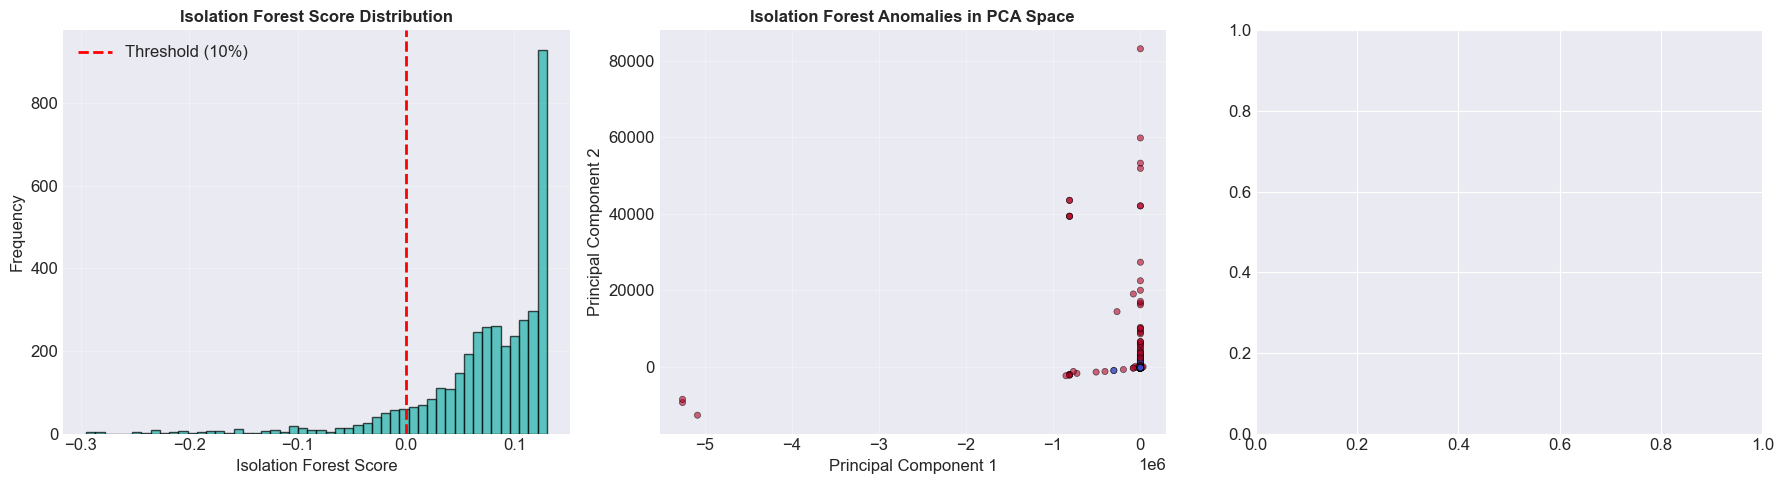

In [15]:
# Visualize Isolation Forest results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Anomaly score distribution
axes[0].hist(iso_scores, bins=50, edgecolor='black', alpha=0.7, color='lightseagreen')
axes[0].axvline(np.percentile(iso_scores, selected_contam * 100), 
                color='red', linestyle='--', linewidth=2,
                label=f'Threshold ({selected_contam:.0%})')
axes[0].set_xlabel('Isolation Forest Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Isolation Forest Score Distribution', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Anomalies in PCA space
scatter = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=iso_anomalies, cmap='coolwarm',
                         alpha=0.6, s=20, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel(f'Principal Component 1')
axes[1].set_ylabel(f'Principal Component 2')
axes[1].set_title('Isolation Forest Anomalies in PCA Space', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Plot 3: Feature importance from Isolation Forest
if hasattr(iso_model, 'feature_importances_'):
    feature_importance = iso_model.feature_importances_
    top_n = min(15, len(feature_names))
    top_indices = np.argsort(feature_importance)[-top_n:][::-1]
    
    bars = axes[2].barh(range(top_n), feature_importance[top_indices])
    axes[2].set_yticks(range(top_n))
    axes[2].set_yticklabels([feature_names[i] for i in top_indices], fontsize=9)
    axes[2].set_xlabel('Feature Importance')
    axes[2].set_title(f'Top {top_n} Features for Anomaly Detection', fontsize=12, fontweight='bold')
    axes[2].invert_yaxis()
    axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ## 5.2 Local Outlier Factor (LOF)
Density-based algorithm that identifies outliers based on local density deviation.


In [16]:
print("\n📍 MACHINE LEARNING: LOCAL OUTLIER FACTOR (LOF)")
print("="*60)

# Train Local Outlier Factor
print("Training Local Outlier Factor...")

# LOF parameters
lof_contamination = 0.1

lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=lof_contamination,
    novelty=False,  # Use standard LOF (not novelty detection)
    n_jobs=-1,
    metric='euclidean'
)

# Fit and predict
lof_predictions = lof.fit_predict(X_scaled)  # 1=normal, -1=anomaly
lof_scores = lof.negative_outlier_factor_  # Lower = more anomalous

# Convert to binary (1=anomaly, 0=normal)
lof_anomalies = (lof_predictions == -1).astype(int)

print(f"✅ LOF analysis completed (contamination={lof_contamination:.0%})")
print(f"   • Anomalies detected: {lof_anomalies.sum():,} ({lof_anomalies.sum()/len(lof_anomalies):.2%})")
print(f"   • LOF score range: [{lof_scores.min():.3f}, {lof_scores.max():.3f}]")
print(f"   • More negative score = more anomalous")


📍 MACHINE LEARNING: LOCAL OUTLIER FACTOR (LOF)
Training Local Outlier Factor...
✅ LOF analysis completed (contamination=10%)
   • Anomalies detected: 390 (10.02%)
   • LOF score range: [-24795.310, -0.912]
   • More negative score = more anomalous


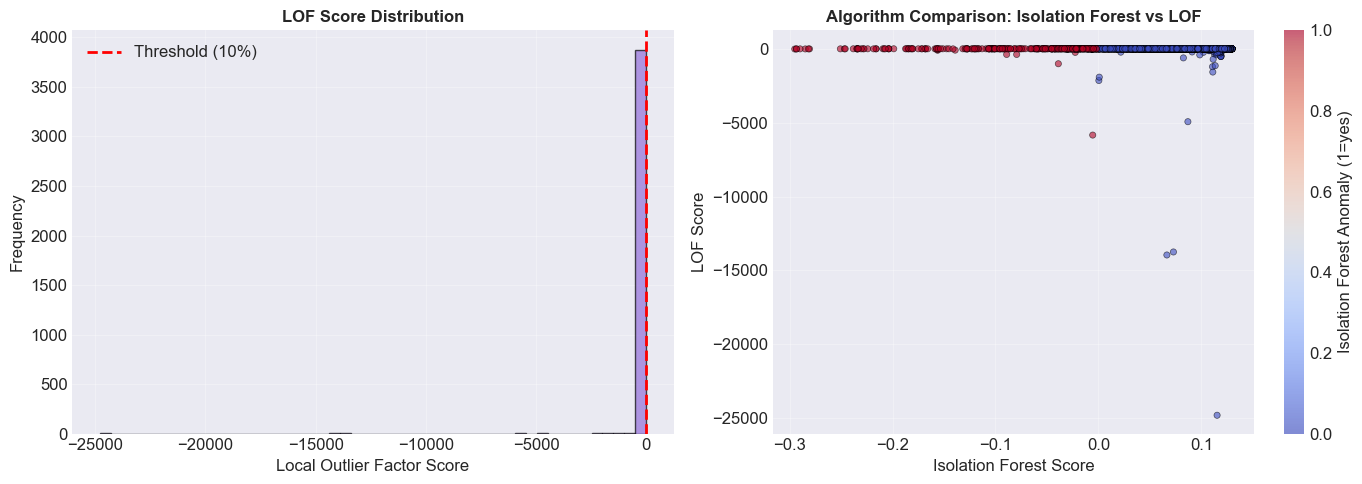

In [17]:
# Visualize LOF results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: LOF score distribution
axes[0].hist(lof_scores, bins=50, edgecolor='black', alpha=0.7, color='mediumpurple')
axes[0].axvline(np.percentile(lof_scores, lof_contamination * 100), 
                color='red', linestyle='--', linewidth=2,
                label=f'Threshold ({lof_contamination:.0%})')
axes[0].set_xlabel('Local Outlier Factor Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('LOF Score Distribution', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Comparison with Isolation Forest
scatter = axes[1].scatter(iso_scores, lof_scores, 
                         c=iso_anomalies, cmap='coolwarm',
                         alpha=0.6, s=20, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel('Isolation Forest Score')
axes[1].set_ylabel('LOF Score')
axes[1].set_title('Algorithm Comparison: Isolation Forest vs LOF', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.colorbar(scatter, ax=axes[1], label='Isolation Forest Anomaly (1=yes)')
plt.tight_layout()
plt.show()

# 5.3 One-Class SVM
# Support Vector Machine for novelty detection.

In [18]:
print("\n⚙️ MACHINE LEARNING: ONE-CLASS SVM")
print("="*60)

# Train One-Class SVM (use subset for speed if dataset is large)
print("Training One-Class SVM...")

# Use subset if dataset is large
max_samples = 10000
if len(X_scaled) > max_samples:
    print(f"  Dataset large ({len(X_scaled):,} samples). Using {max_samples:,} samples for training...")
    indices = np.random.choice(len(X_scaled), max_samples, replace=False)
    X_svm = X_scaled[indices]
else:
    X_svm = X_scaled

# Train One-Class SVM
oc_svm = OneClassSVM(
    kernel='rbf',
    gamma='scale',
    nu=0.1,  # Expected proportion of outliers
    verbose=True
)

oc_svm.fit(X_svm)

# Predict on full dataset
svm_predictions = oc_svm.predict(X_scaled)  # 1=normal, -1=anomaly
svm_scores = oc_svm.decision_function(X_scaled)  # Signed distance to hyperplane

# Convert to binary (1=anomaly, 0=normal)
svm_anomalies = (svm_predictions == -1).astype(int)

print(f"\n✅ One-Class SVM analysis completed")
print(f"   • Anomalies detected: {svm_anomalies.sum():,} ({svm_anomalies.sum()/len(svm_anomalies):.2%})")
print(f"   • SVM score range: [{svm_scores.min():.3f}, {svm_scores.max():.3f}]")


⚙️ MACHINE LEARNING: ONE-CLASS SVM
Training One-Class SVM...
[LibSVM]
✅ One-Class SVM analysis completed
   • Anomalies detected: 397 (10.20%)
   • SVM score range: [-363.539, 0.041]


# 6.1 Combine Multiple Algorithms
Create ensemble anomaly scores by combining multiple detection methods.

In [19]:
print("\n🤝 ENSEMBLE ANOMALY DETECTION")
print("="*60)

# Collect results from all methods
anomaly_results = {
    'Z_Score': z_anomalies,
    'IQR': iqr_anomalies,
    'Isolation_Forest': iso_anomalies,
    'LOF': lof_anomalies,
    'OneClass_SVM': svm_anomalies
}

# Create ensemble DataFrame
ensemble_df = pd.DataFrame(anomaly_results)
ensemble_df['Account_Number'] = customer_ids

print("📊 Individual Method Results:")
method_summary = pd.DataFrame({
    'Method': list(anomaly_results.keys()),
    'Anomalies_Detected': [anomalies.sum() for anomalies in anomaly_results.values()],
    'Anomaly_Rate': [anomalies.sum()/len(anomalies) for anomalies in anomaly_results.values()]
})
display(method_summary.style.background_gradient(subset=['Anomaly_Rate'], cmap='Reds'))


🤝 ENSEMBLE ANOMALY DETECTION
📊 Individual Method Results:


,Method,Anomalies_Detected,Anomaly_Rate
0,Z_Score,843,0.216543
1,IQR,3353,0.861289
2,Isolation_Forest,389,0.099923
3,LOF,390,0.100180
4,OneClass_SVM,397,0.101978


In [20]:
# Create ensemble scores (voting system)
print("\nCreating ensemble scores...")

# Method 1: Simple voting
ensemble_df['Vote_Count'] = ensemble_df[list(anomaly_results.keys())].sum(axis=1)
ensemble_df['Vote_Ratio'] = ensemble_df['Vote_Count'] / len(anomaly_results)

# Method 2: Weighted ensemble (weight by algorithm confidence)
# For simplicity, we'll use equal weights
weights = {
    'Z_Score': 0.8,      # Statistical method
    'IQR': 0.8,          # Statistical method  
    'Isolation_Forest': 1.0,  # Strong ML method
    'LOF': 0.9,          # Density-based method
    'OneClass_SVM': 0.7  # Can be sensitive to parameters
}

weighted_scores = np.zeros(len(ensemble_df))
for method, weight in weights.items():
    weighted_scores += ensemble_df[method] * weight

ensemble_df['Weighted_Score'] = weighted_scores / sum(weights.values())

# Method 3: Consensus approach (at least 2 methods agree)
ensemble_df['Consensus_Anomaly'] = (ensemble_df['Vote_Count'] >= 2).astype(int)

print("✅ Ensemble scores created")
print(f"   • Voting: {ensemble_df['Vote_Count'].describe().round(2).to_dict()}")
print(f"   • Weighted: {ensemble_df['Weighted_Score'].describe().round(2).to_dict()}")
print(f"   • Consensus anomalies: {ensemble_df['Consensus_Anomaly'].sum():,}")


Creating ensemble scores...
✅ Ensemble scores created
   • Voting: {'count': 3893.0, 'mean': 1.38, 'std': 1.05, 'min': 0.0, '25%': 1.0, '50%': 1.0, '75%': 2.0, 'max': 5.0}
   • Weighted: {'count': 3893.0, 'mean': 0.27, 'std': 0.21, 'min': 0.0, '25%': 0.19, '50%': 0.19, '75%': 0.38, 'max': 1.0}
   • Consensus anomalies: 1,186


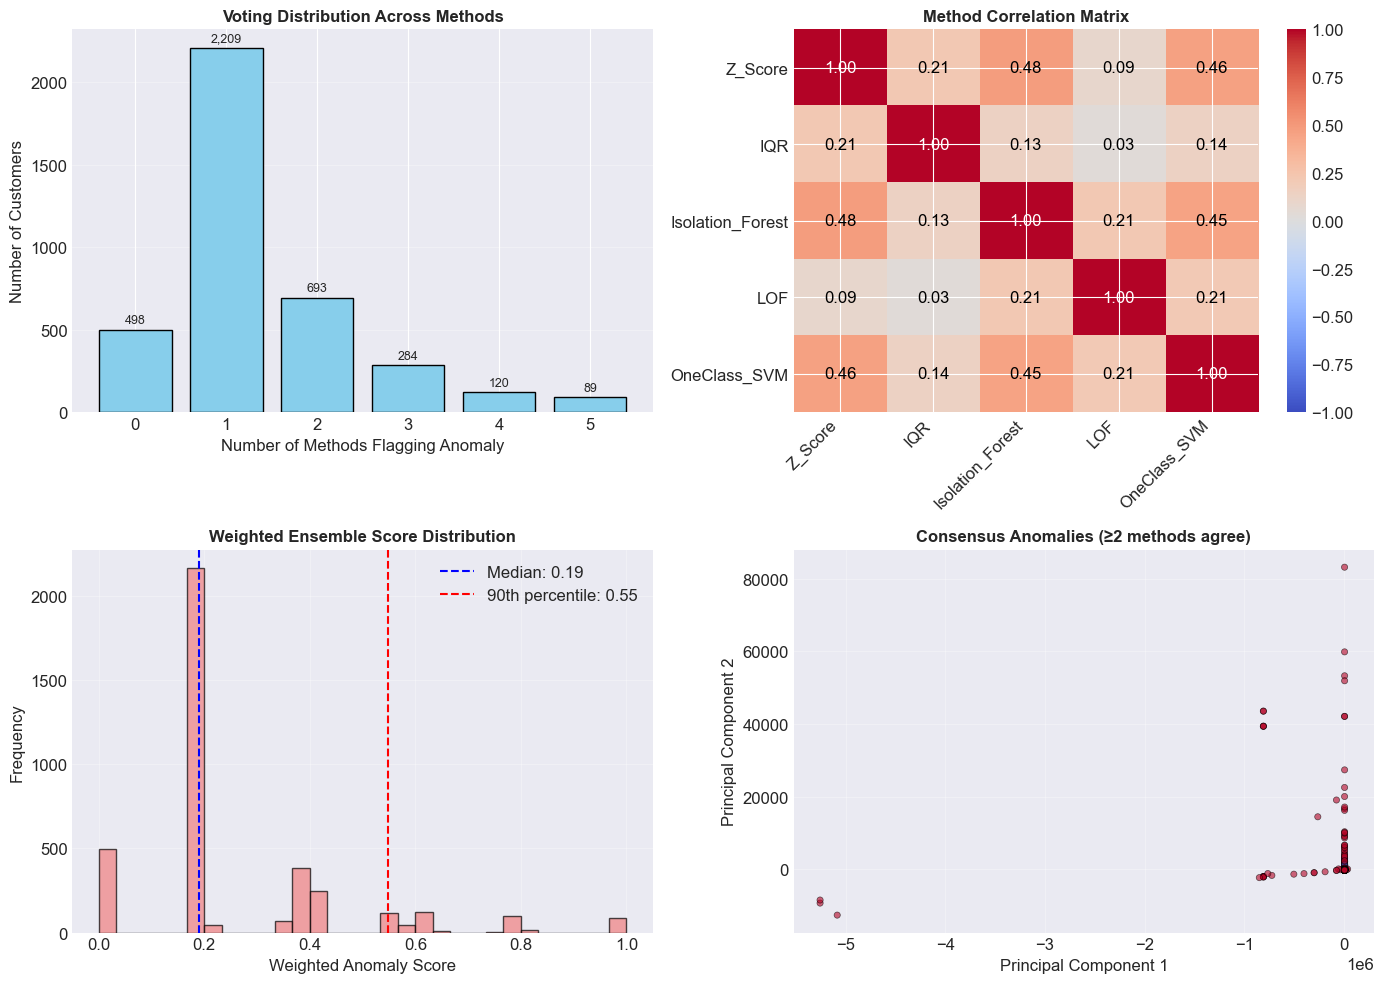

In [22]:
# Visualize ensemble results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Vote distribution
vote_counts = ensemble_df['Vote_Count'].value_counts().sort_index()
bars1 = axes[0, 0].bar(vote_counts.index, vote_counts.values, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Number of Methods Flagging Anomaly')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].set_title('Voting Distribution Across Methods', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, height + max(vote_counts.values)*0.01,
                   f'{int(height):,}', ha='center', va='bottom', fontsize=9)

# Plot 2: Correlation between methods
method_corr = ensemble_df[list(anomaly_results.keys())].corr()
im = axes[0, 1].imshow(method_corr, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
axes[0, 1].set_xticks(range(len(method_corr)))
axes[0, 1].set_yticks(range(len(method_corr)))
axes[0, 1].set_xticklabels(method_corr.columns, rotation=45, ha='right')
axes[0, 1].set_yticklabels(method_corr.columns)
axes[0, 1].set_title('Method Correlation Matrix', fontsize=12, fontweight='bold')

# Add correlation values
for i in range(len(method_corr)):
    for j in range(len(method_corr)):
        text = axes[0, 1].text(j, i, f'{method_corr.iloc[i, j]:.2f}',
                              ha="center", va="center", color="black" if abs(method_corr.iloc[i, j]) < 0.5 else "white")

plt.colorbar(im, ax=axes[0, 1])

# Plot 3: Weighted score distribution
axes[1, 0].hist(ensemble_df['Weighted_Score'], bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1, 0].axvline(ensemble_df['Weighted_Score'].median(), color='blue', linestyle='--', 
                   label=f'Median: {ensemble_df["Weighted_Score"].median():.2f}')
axes[1, 0].axvline(ensemble_df['Weighted_Score'].quantile(0.9), color='red', linestyle='--',
                   label=f'90th percentile: {ensemble_df["Weighted_Score"].quantile(0.9):.2f}')
axes[1, 0].set_xlabel('Weighted Anomaly Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Weighted Ensemble Score Distribution', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Consensus anomalies in PCA space
scatter = axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], 
                            c=ensemble_df['Consensus_Anomaly'], cmap='coolwarm',
                            alpha=0.6, s=20, edgecolors='k', linewidth=0.5)
axes[1, 1].set_xlabel(f'Principal Component 1')
axes[1, 1].set_ylabel(f'Principal Component 2')
axes[1, 1].set_title('Consensus Anomalies (≥2 methods agree)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7.1 Segment Customers by Behavior
Apply different anomaly detection strategies for different customer segments.

In [23]:
print("\n🎯 CUSTOMER SEGMENTATION FOR TARGETED DETECTION")
print("="*60)

# Create customer segments based on behavior
if 'Transaction_Frequency' in df_features.columns and 'Avg_Transaction_Amount' in df_features.columns:
    # Use RFM-style segmentation
    transaction_freq = df_features['Transaction_Frequency'].values
    avg_amount = df_features['Avg_Transaction_Amount'].values
    
    # Segment by frequency
    freq_quantiles = np.percentile(transaction_freq, [33, 67])
    freq_segments = np.digitize(transaction_freq, freq_quantiles)  # 0=low, 1=medium, 2=high
    
    # Segment by amount
    amount_quantiles = np.percentile(avg_amount, [33, 67])
    amount_segments = np.digitize(avg_amount, amount_quantiles)  # 0=low, 1=medium, 2=high
    
    # Create combined segments (3x3 matrix)
    segment_matrix = freq_segments * 3 + amount_segments  # 0-8 segments
    
    # Name the segments
    segment_names = {
        0: 'Low Freq - Low Value',
        1: 'Low Freq - Medium Value',
        2: 'Low Freq - High Value',
        3: 'Medium Freq - Low Value',
        4: 'Medium Freq - Medium Value',
        5: 'Medium Freq - High Value',
        6: 'High Freq - Low Value',
        7: 'High Freq - Medium Value',
        8: 'High Freq - High Value'
    }
    
    # Add segments to DataFrame
    ensemble_df['Segment_Code'] = segment_matrix
    ensemble_df['Segment_Name'] = ensemble_df['Segment_Code'].map(segment_names)
    
    print(f"✅ Created {len(segment_names)} customer segments")
    print("\n📊 Segment Distribution:")
    segment_counts = ensemble_df['Segment_Name'].value_counts()
    for segment, count in segment_counts.items():
        print(f"   • {segment:30s}: {count:6,} customers ({count/len(ensemble_df):.1%})")
    
else:
    print("⚠️ Required features not found for segmentation")
    # Create simple segments based on PCA clusters
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_pca)
    
    segment_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3'}
    ensemble_df['Segment_Code'] = cluster_labels
    ensemble_df['Segment_Name'] = ensemble_df['Segment_Code'].map(segment_names)
    
    print(f"✅ Created {len(segment_names)} segments using PCA clustering")


🎯 CUSTOMER SEGMENTATION FOR TARGETED DETECTION
⚠️ Required features not found for segmentation
✅ Created 3 segments using PCA clustering


In [24]:
# Analyze anomalies by segment
segment_analysis = ensemble_df.groupby('Segment_Name').agg({
    'Account_Number': 'count',
    'Consensus_Anomaly': 'sum',
    'Weighted_Score': 'mean',
    'Vote_Ratio': 'mean'
}).reset_index()

segment_analysis = segment_analysis.rename(columns={
    'Account_Number': 'Total_Customers',
    'Consensus_Anomaly': 'Anomaly_Count'
})

segment_analysis['Anomaly_Rate'] = segment_analysis['Anomaly_Count'] / segment_analysis['Total_Customers']
segment_analysis = segment_analysis.sort_values('Anomaly_Rate', ascending=False)

print("\n📊 Anomaly Analysis by Customer Segment:")
display(segment_analysis.style.background_gradient(subset=['Anomaly_Rate', 'Weighted_Score'], cmap='Reds'))


📊 Anomaly Analysis by Customer Segment:


,Segment_Name,Total_Customers,Anomaly_Count,Weighted_Score,Vote_Ratio,Anomaly_Rate
1,Cluster 2,3,3,1.000000,1.000000,1.000000
2,Cluster 3,15,15,0.944444,0.946667,1.000000
0,Cluster 1,3875,1168,0.264369,0.272826,0.301419


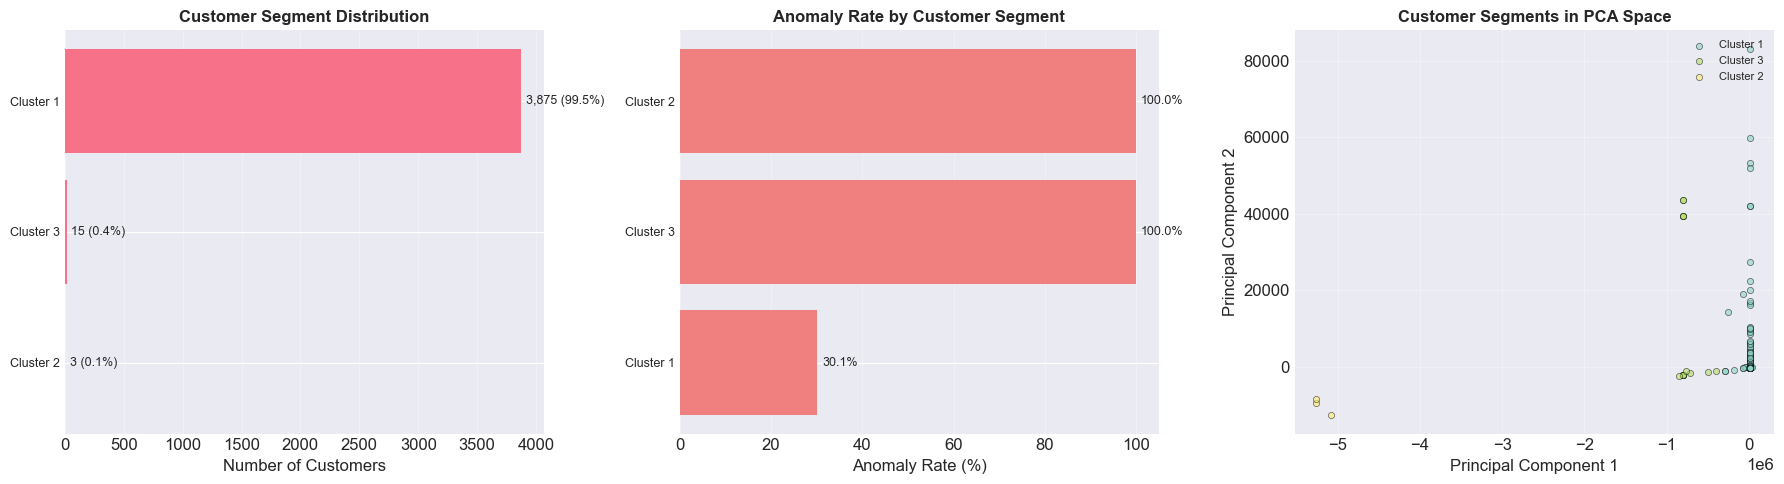

In [25]:
# Visualize segmentation results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Segment distribution
segment_counts = ensemble_df['Segment_Name'].value_counts()
bars = axes[0].barh(range(len(segment_counts)), segment_counts.values)
axes[0].set_yticks(range(len(segment_counts)))
axes[0].set_yticklabels(segment_counts.index, fontsize=9)
axes[0].set_xlabel('Number of Customers')
axes[0].set_title('Customer Segment Distribution', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, count) in enumerate(zip(bars, segment_counts.values)):
    axes[0].text(count + max(segment_counts.values)*0.01, bar.get_y() + bar.get_height()/2,
                f'{count:,} ({count/len(ensemble_df):.1%})', 
                va='center', fontsize=9)

# Plot 2: Anomaly rate by segment
segment_rates = segment_analysis.set_index('Segment_Name')['Anomaly_Rate']
bars = axes[1].barh(range(len(segment_rates)), segment_rates.values * 100, color='lightcoral')
axes[1].set_yticks(range(len(segment_rates)))
axes[1].set_yticklabels(segment_rates.index, fontsize=9)
axes[1].set_xlabel('Anomaly Rate (%)')
axes[1].set_title('Anomaly Rate by Customer Segment', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, rate) in enumerate(zip(bars, segment_rates.values)):
    axes[1].text(rate*100 + max(segment_rates.values)*100*0.01, bar.get_y() + bar.get_height()/2,
                f'{rate*100:.1f}%', va='center', fontsize=9)

# Plot 3: Segments in PCA space
unique_segments = ensemble_df['Segment_Name'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_segments)))

for segment, color in zip(unique_segments, colors):
    mask = ensemble_df['Segment_Name'] == segment
    axes[2].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   label=segment, alpha=0.6, s=20, color=color, edgecolors='k', linewidth=0.5)

axes[2].set_xlabel(f'Principal Component 1')
axes[2].set_ylabel(f'Principal Component 2')
axes[2].set_title('Customer Segments in PCA Space', fontsize=12, fontweight='bold')
axes[2].legend(loc='upper right', fontsize=8)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8.1 Create Comprehensive Risk Scores
Combine anomaly detection results with business rules to create risk scores.

In [26]:
print("\n⚠️ RISK SCORING AND PRIORITIZATION")
print("="*60)

# Create comprehensive risk score
print("Calculating comprehensive risk scores...")

# Start with weighted ensemble score (0-1 scale)
ensemble_df['Risk_Score_Raw'] = ensemble_df['Weighted_Score']

# Apply business rule adjustments
risk_adjustments = []

# Adjustment 1: Higher weight for consensus anomalies
consensus_adjustment = ensemble_df['Consensus_Anomaly'] * 0.2
risk_adjustments.append(('Consensus Bonus', consensus_adjustment))

# Adjustment 2: Segment-based adjustments (high-value segments get higher scrutiny)
if 'Segment_Name' in ensemble_df.columns:
    segment_risk_factors = {
        'High Freq - High Value': 0.3,
        'High Freq - Medium Value': 0.2,
        'Medium Freq - High Value': 0.2,
        'High Freq - Low Value': 0.1,
        'Medium Freq - Medium Value': 0.1,
        'Low Freq - High Value': 0.3,  # Low frequency but high value is suspicious
        'Medium Freq - Low Value': 0.0,
        'Low Freq - Medium Value': 0.0,
        'Low Freq - Low Value': -0.1  # Low risk segment
    }
    
    segment_adjustment = ensemble_df['Segment_Name'].map(segment_risk_factors).fillna(0)
    risk_adjustments.append(('Segment Adjustment', segment_adjustment))

# Adjustment 3: Recent activity (if date information available)
if 'Last_Transaction_Date' in df_features.columns:
    # Convert to recency score (more recent = potentially higher risk)
    try:
        df_features['Last_Transaction_Date'] = pd.to_datetime(df_features['Last_Transaction_Date'])
        max_date = df_features['Last_Transaction_Date'].max()
        recency_days = (max_date - df_features['Last_Transaction_Date']).dt.days
        
        # Normalize and invert (more recent = higher score)
        recency_score = 1 - (recency_days / recency_days.max())
        recency_adjustment = recency_score * 0.15
        
        risk_adjustments.append(('Recency Adjustment', recency_adjustment))
    except:
        print("  ⚠️ Could not calculate recency adjustment")

# Calculate final risk score
final_risk_score = ensemble_df['Risk_Score_Raw'].copy()

print("\n📊 Risk Score Adjustments Applied:")
for adjustment_name, adjustment_values in risk_adjustments:
    final_risk_score += adjustment_values
    print(f"   • {adjustment_name:20s}: {adjustment_values.mean():+.3f} (avg)")

# Cap score between 0 and 1
final_risk_score = np.clip(final_risk_score, 0, 1)

ensemble_df['Risk_Score_Final'] = final_risk_score

# Create risk categories
def categorize_risk(score):
    if score < 0.3:
        return 'Low Risk'
    elif score < 0.6:
        return 'Medium Risk'
    elif score < 0.8:
        return 'High Risk'
    else:
        return 'Critical Risk'

ensemble_df['Risk_Category'] = ensemble_df['Risk_Score_Final'].apply(categorize_risk)

print(f"\n✅ Final risk scores calculated (range: {final_risk_score.min():.3f} - {final_risk_score.max():.3f})")
print(f"📊 Risk Category Distribution:")
risk_counts = ensemble_df['Risk_Category'].value_counts()
for category, count in risk_counts.items():
    print(f"   • {category:15s}: {count:6,} customers ({count/len(ensemble_df):.1%})")


⚠️ RISK SCORING AND PRIORITIZATION
Calculating comprehensive risk scores...

📊 Risk Score Adjustments Applied:
   • Consensus Bonus     : +0.061 (avg)
   • Segment Adjustment  : +0.000 (avg)
   • Recency Adjustment  : +0.116 (avg)

✅ Final risk scores calculated (range: 0.144 - 1.000)
📊 Risk Category Distribution:
   • Medium Risk    :  1,769 customers (45.4%)
   • Low Risk       :  1,046 customers (26.9%)
   • High Risk      :    611 customers (15.7%)
   • Critical Risk  :    467 customers (12.0%)


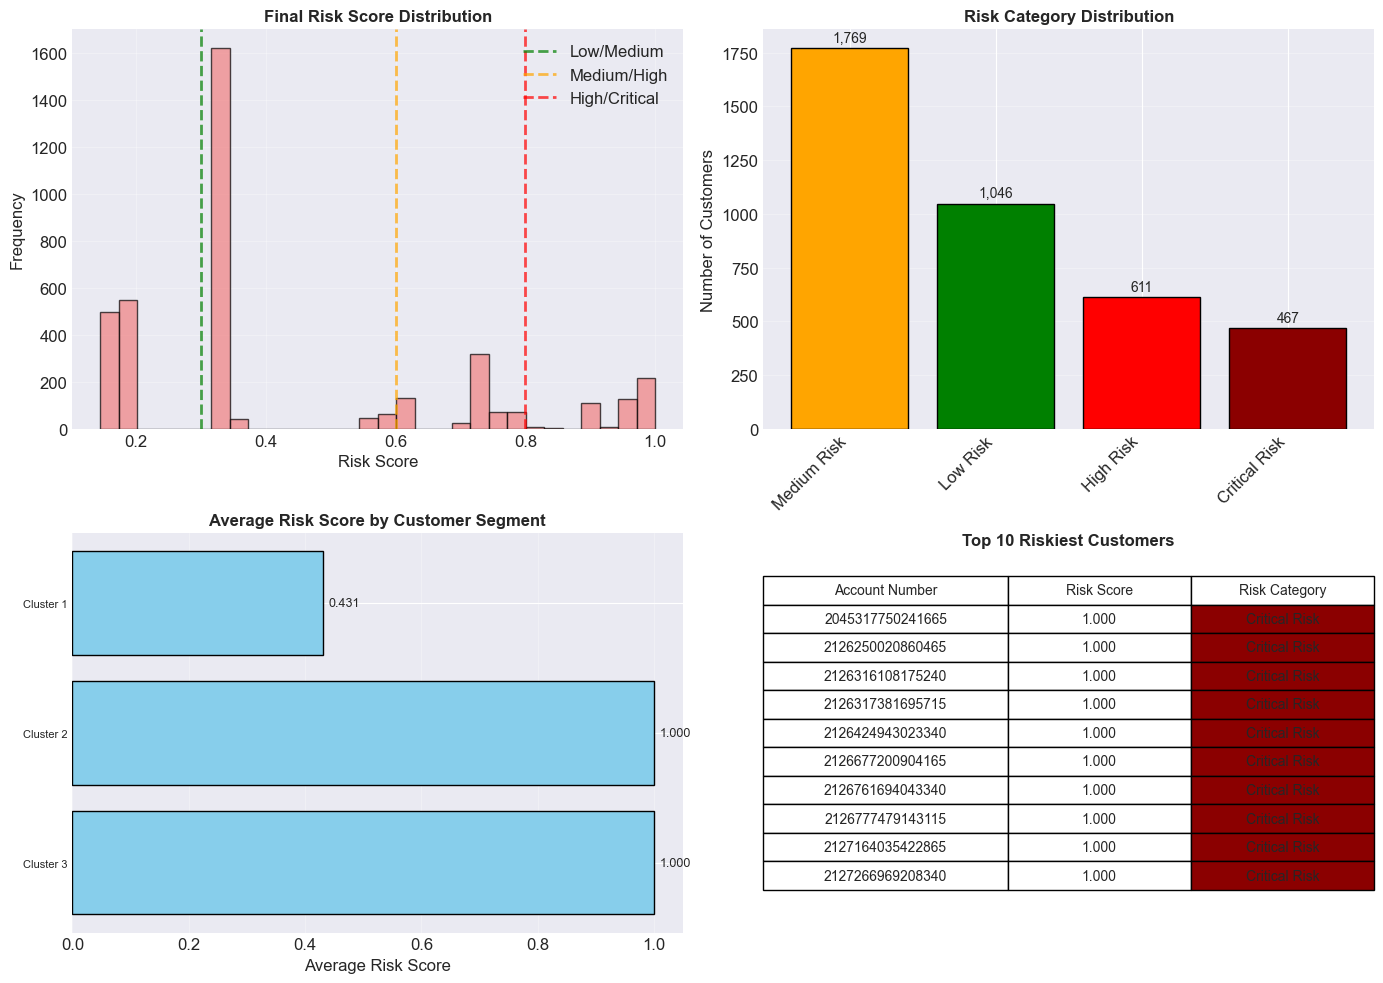

In [27]:
# Visualize risk scoring results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Risk score distribution
axes[0, 0].hist(ensemble_df['Risk_Score_Final'], bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
axes[0, 0].axvline(0.3, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Low/Medium')
axes[0, 0].axvline(0.6, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Medium/High')
axes[0, 0].axvline(0.8, color='red', linestyle='--', linewidth=2, alpha=0.7, label='High/Critical')
axes[0, 0].set_xlabel('Risk Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Final Risk Score Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Risk categories
category_counts = ensemble_df['Risk_Category'].value_counts()
category_colors = {'Low Risk': 'green', 'Medium Risk': 'orange', 
                   'High Risk': 'red', 'Critical Risk': 'darkred'}
bar_colors = [category_colors[cat] for cat in category_counts.index]

bars = axes[0, 1].bar(range(len(category_counts)), category_counts.values, color=bar_colors, edgecolor='black')
axes[0, 1].set_xticks(range(len(category_counts)))
axes[0, 1].set_xticklabels(category_counts.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].set_title('Risk Category Distribution', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, count in zip(bars, category_counts.values):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, height + max(category_counts.values)*0.01,
                   f'{int(count):,}', ha='center', va='bottom', fontsize=10)

# Plot 3: Risk by segment
if 'Segment_Name' in ensemble_df.columns:
    risk_by_segment = ensemble_df.groupby('Segment_Name')['Risk_Score_Final'].mean().sort_values()
    bars = axes[1, 0].barh(range(len(risk_by_segment)), risk_by_segment.values, color='skyblue', edgecolor='black')
    axes[1, 0].set_yticks(range(len(risk_by_segment)))
    axes[1, 0].set_yticklabels(risk_by_segment.index, fontsize=8)
    axes[1, 0].set_xlabel('Average Risk Score')
    axes[1, 0].set_title('Average Risk Score by Customer Segment', fontsize=12, fontweight='bold')
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, score) in enumerate(zip(bars, risk_by_segment.values)):
        axes[1, 0].text(score + risk_by_segment.max()*0.01, bar.get_y() + bar.get_height()/2,
                       f'{score:.3f}', va='center', fontsize=9)

# Plot 4: Top risky customers
top_risky = ensemble_df.nlargest(10, 'Risk_Score_Final')[['Account_Number', 'Risk_Score_Final', 'Risk_Category']]
top_risky = top_risky.reset_index(drop=True)
top_risky.index = top_risky.index + 1  # Start from 1

# Create table
cell_text = []
for _, row in top_risky.iterrows():
    cell_text.append([f"{row['Account_Number']}", f"{row['Risk_Score_Final']:.3f}", row['Risk_Category']])

axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table = axes[1, 1].table(cellText=cell_text,
                        colLabels=['Account Number', 'Risk Score', 'Risk Category'],
                        cellLoc='center',
                        loc='center',
                        colWidths=[0.4, 0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
axes[1, 1].set_title('Top 10 Riskiest Customers', fontsize=12, fontweight='bold', y=0.95)

# Color cells based on risk category
for i in range(1, len(top_risky) + 1):
    category = cell_text[i-1][2]
    color = category_colors.get(category, 'white')
    table[(i, 2)].set_facecolor(color)

plt.tight_layout()
plt.show()

# 9.1 Evaluate Anomaly Detection Performance
Since we don't have labeled anomalies, use synthetic validation and consistency checks.

In [29]:
print("\n📈 MODEL EVALUATION AND VALIDATION")
print("="*60)

# Create synthetic validation (for demonstration)
print("Creating synthetic validation set...")

# Method 1: Internal consistency (should be repeatable)
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test = train_test_split(X_scaled, test_size=0.3, random_state=42)

# Train Isolation Forest on training set
iso_forest_val = IsolationForest(
    n_estimators=100,
    contamination=0.1,
    random_state=42,
    n_jobs=-1
)
iso_forest_val.fit(X_train)

# Predict on test set
test_scores = iso_forest_val.decision_function(X_test)
test_predictions = iso_forest_val.predict(X_test)
test_anomalies = (test_predictions == -1).astype(int)

print(f"✅ Validation model trained")
print(f"   • Training samples: {X_train.shape[0]:,}")
print(f"   • Test samples: {X_test.shape[0]:,}")
print(f"   • Anomalies in test set: {test_anomalies.sum():,} ({test_anomalies.sum()/len(test_anomalies):.2%})")

# Method 2: Stability analysis (check if results are stable)
print("\n🔍 Stability Analysis (different random seeds):")
stability_results = []
for seed in [42, 123, 456]:
    iso_temp = IsolationForest(
        n_estimators=100,
        contamination=0.1,
        random_state=seed,
        n_jobs=-1
    )
    iso_temp.fit(X_scaled)
    temp_preds = iso_temp.predict(X_scaled)
    temp_anomalies = (temp_preds == -1).sum()
    stability_results.append(temp_anomalies)
    print(f"   • Seed {seed}: {temp_anomalies:,} anomalies")

stability_range = max(stability_results) - min(stability_results)
stability_pct = stability_range / np.mean(stability_results)
print(f"   • Stability range: {stability_range:,} anomalies ({stability_pct:.1%} variation)")


📈 MODEL EVALUATION AND VALIDATION
Creating synthetic validation set...
✅ Validation model trained
   • Training samples: 2,725
   • Test samples: 1,168
   • Anomalies in test set: 132 (11.30%)

🔍 Stability Analysis (different random seeds):
   • Seed 42: 389 anomalies
   • Seed 123: 390 anomalies
   • Seed 456: 390 anomalies
   • Stability range: 1 anomalies (0.3% variation)


In [30]:
# Create evaluation metrics based on business rules
print("\n📊 Business Rule Validation:")

# Rule 1: High-risk customers should have unusual behavior patterns
if 'Channel_Deviation_Rate' in df_features.columns:
    high_risk_mask = ensemble_df['Risk_Category'].isin(['High Risk', 'Critical Risk'])
    channel_dev_high_risk = df_features.loc[high_risk_mask, 'Channel_Deviation_Rate'].mean()
    channel_dev_low_risk = df_features.loc[~high_risk_mask, 'Channel_Deviation_Rate'].mean()
    
    print(f"   • Channel Deviation Rate:")
    print(f"     - High Risk customers: {channel_dev_high_risk:.3f}")
    print(f"     - Low Risk customers: {channel_dev_low_risk:.3f}")
    print(f"     - Difference: {channel_dev_high_risk - channel_dev_low_risk:.3f}")

# Rule 2: High-risk customers should have higher transaction amounts
if 'Avg_Transaction_Amount' in df_features.columns:
    amount_high_risk = df_features.loc[high_risk_mask, 'Avg_Transaction_Amount'].mean()
    amount_low_risk = df_features.loc[~high_risk_mask, 'Avg_Transaction_Amount'].mean()
    
    print(f"   • Average Transaction Amount:")
    print(f"     - High Risk customers: {amount_high_risk:,.0f}")
    print(f"     - Low Risk customers: {amount_low_risk:,.0f}")
    print(f"     - Ratio: {amount_high_risk/amount_low_risk:.1f}x")

# Rule 3: High-risk customers should have unusual location patterns
if 'Location_Anomaly_Rate' in df_features.columns:
    location_high_risk = df_features.loc[high_risk_mask, 'Location_Anomaly_Rate'].mean()
    location_low_risk = df_features.loc[~high_risk_mask, 'Location_Anomaly_Rate'].mean()
    
    print(f"   • Location Anomaly Rate:")
    print(f"     - High Risk customers: {location_high_risk:.3f}")
    print(f"     - Low Risk customers: {location_low_risk:.3f}")
    print(f"     - Difference: {location_high_risk - location_low_risk:.3f}")


📊 Business Rule Validation:


# 10.1 Export All Results
Save anomaly detection results for business use.

In [31]:
print("\n💾 EXPORTING ANOMALY DETECTION RESULTS")
print("="*60)

import os

# Create output directory
output_dir = '../data/outputs/anomaly_results'
os.makedirs(output_dir, exist_ok=True)

print(f"Output directory: {output_dir}")

# 1. Export comprehensive results
results_df = ensemble_df.copy()

# Add original features for context
if 'df_features' in locals():
    # Merge with important original features
    feature_cols_to_include = ['Transaction_Frequency', 'Avg_Transaction_Amount', 
                               'Total_Transaction_Amount', 'Customer_Lifetime_Days',
                               'Channel_Diversity_Score', 'Location_Anomaly_Rate']
    
    # Check which features exist
    available_features = [col for col in feature_cols_to_include if col in df_features.columns]
    
    if available_features:
        features_to_include = df_features[['Account_Number'] + available_features]
        results_df = results_df.merge(features_to_include, on='Account_Number', how='left')
        print(f"✅ Added {len(available_features)} original features")

# Sort by risk score
results_df = results_df.sort_values('Risk_Score_Final', ascending=False)

# Save comprehensive results
comprehensive_path = f'{output_dir}/comprehensive_anomaly_results.csv'
results_df.to_csv(comprehensive_path, index=False)
print(f"✅ Comprehensive results saved: {comprehensive_path}")
print(f"   • Total records: {len(results_df):,}")
print(f"   • Columns: {len(results_df.columns)}")


💾 EXPORTING ANOMALY DETECTION RESULTS
Output directory: ../data/outputs/anomaly_results
✅ Comprehensive results saved: ../data/outputs/anomaly_results/comprehensive_anomaly_results.csv
   • Total records: 3,893
   • Columns: 15


In [32]:
# 2. Export high-risk customers (for immediate action)
high_risk_customers = results_df[
    results_df['Risk_Category'].isin(['High Risk', 'Critical Risk'])
].copy()

# Add investigation priority
def set_investigation_priority(row):
    if row['Risk_Category'] == 'Critical Risk':
        return 'Immediate'
    elif row['Risk_Score_Final'] > 0.7:
        return 'High'
    elif row['Risk_Score_Final'] > 0.5:
        return 'Medium'
    else:
        return 'Low'

high_risk_customers['Investigation_Priority'] = high_risk_customers.apply(set_investigation_priority, axis=1)

# Select important columns for investigation
investigation_cols = ['Account_Number', 'Risk_Score_Final', 'Risk_Category', 
                      'Investigation_Priority', 'Vote_Ratio', 'Consensus_Anomaly']

if 'Transaction_Frequency' in high_risk_customers.columns:
    investigation_cols.append('Transaction_Frequency')
if 'Avg_Transaction_Amount' in high_risk_customers.columns:
    investigation_cols.append('Avg_Transaction_Amount')
if 'Total_Transaction_Amount' in high_risk_customers.columns:
    investigation_cols.append('Total_Transaction_Amount')
if 'Segment_Name' in high_risk_customers.columns:
    investigation_cols.append('Segment_Name')

high_risk_customers = high_risk_customers[investigation_cols]

# Save high-risk customers
high_risk_path = f'{output_dir}/high_risk_customers.csv'
high_risk_customers.to_csv(high_risk_path, index=False)
print(f"✅ High-risk customers saved: {high_risk_path}")
print(f"   • High/Critical risk customers: {len(high_risk_customers):,}")
print(f"   • Immediate priority: {high_risk_customers[high_risk_customers['Investigation_Priority'] == 'Immediate'].shape[0]:,}")
print(f"   • High priority: {high_risk_customers[high_risk_customers['Investigation_Priority'] == 'High'].shape[0]:,}")

✅ High-risk customers saved: ../data/outputs/anomaly_results/high_risk_customers.csv
   • High/Critical risk customers: 1,078
   • Immediate priority: 467
   • High priority: 479


In [33]:
# 3. Export model performance summary
performance_summary = pd.DataFrame({
    'Metric': [
        'Total Customers Analyzed',
        'Anomalies Detected (Consensus)',
        'High/Critical Risk Customers',
        'Average Risk Score',
        'Risk Score Standard Deviation',
        'Percentage High/Critical Risk',
        'Model Stability Variation',
        'Training Samples',
        'Features Used'
    ],
    'Value': [
        len(results_df),
        results_df['Consensus_Anomaly'].sum(),
        len(high_risk_customers),
        results_df['Risk_Score_Final'].mean(),
        results_df['Risk_Score_Final'].std(),
        len(high_risk_customers) / len(results_df),
        f"{stability_pct:.1%}" if 'stability_pct' in locals() else 'N/A',
        X_train.shape[0] if 'X_train' in locals() else 'N/A',
        X_scaled.shape[1]
    ]
})

performance_path = f'{output_dir}/model_performance_summary.csv'
performance_summary.to_csv(performance_path, index=False)
print(f"✅ Performance summary saved: {performance_path}")

✅ Performance summary saved: ../data/outputs/anomaly_results/model_performance_summary.csv


In [34]:
# 4. Export visualization data for dashboard
viz_data = pd.DataFrame({
    'Account_Number': customer_ids,
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Risk_Score': results_df['Risk_Score_Final'].values,
    'Risk_Category': results_df['Risk_Category'].values,
    'Consensus_Anomaly': results_df['Consensus_Anomaly'].values
})

# Add segment if available
if 'Segment_Name' in results_df.columns:
    viz_data['Segment'] = results_df['Segment_Name'].values

viz_path = f'{output_dir}/visualization_data.csv'
viz_data.to_csv(viz_path, index=False)
print(f"✅ Visualization data saved: {viz_path}")

✅ Visualization data saved: ../data/outputs/anomaly_results/visualization_data.csv


In [35]:
# 5. Create executive summary report
print("\n📋 CREATING EXECUTIVE SUMMARY REPORT")

executive_summary = f"""
ANOMALY DETECTION REPORT
========================

Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

EXECUTIVE SUMMARY
-----------------
• Total Customers Analyzed: {len(results_df):,}
• Anomalies Detected: {results_df['Consensus_Anomaly'].sum():,} ({results_df['Consensus_Anomaly'].sum()/len(results_df):.1%})
• High/Critical Risk Customers: {len(high_risk_customers):,} ({len(high_risk_customers)/len(results_df):.1%})

RISK BREAKDOWN
--------------
{results_df['Risk_Category'].value_counts().to_string()}

TOP RISK INDICATORS
-------------------
"""

# Add top risk indicators based on feature importance
if 'iso_model' in locals() and hasattr(iso_model, 'feature_importances_'):
    feature_importance = iso_model.feature_importances_
    top_indices = np.argsort(feature_importance)[-5:][::-1]
    
    executive_summary += "\nTop 5 features contributing to anomaly detection:\n"
    for i, idx in enumerate(top_indices, 1):
        if idx < len(feature_names):
            executive_summary += f"{i}. {feature_names[idx]}: {feature_importance[idx]:.3f}\n"

executive_summary += f"""
RECOMMENDED ACTIONS
-------------------
1. **Immediate Investigation** ({high_risk_customers[high_risk_customers['Investigation_Priority'] == 'Immediate'].shape[0]:,} customers):
   • Review transaction patterns
   • Verify customer identity
   • Consider temporary restrictions if warranted

2. **Enhanced Monitoring** ({high_risk_customers[high_risk_customers['Investigation_Priority'] == 'High'].shape[0]:,} customers):
   • Flag for manual review
   • Monitor next transactions closely
   • Update risk scores after each transaction

3. **Model Improvement**:
   • Collect feedback on flagged customers
   • Update model monthly with new data
   • Refine risk scoring rules based on investigation outcomes

NEXT STEPS
----------
• Review detailed reports in visualization dashboard
• Investigate high-priority cases within 48 hours
• Schedule model retraining in 30 days
"""

# Save executive summary
summary_path = f'{output_dir}/executive_summary.txt'
with open(summary_path, 'w') as f:
    f.write(executive_summary)

print(f"✅ Executive summary saved: {summary_path}")
print("\n" + "="*60)
print("📋 EXECUTIVE SUMMARY")
print("="*60)
print(executive_summary)


📋 CREATING EXECUTIVE SUMMARY REPORT
✅ Executive summary saved: ../data/outputs/anomaly_results/executive_summary.txt

📋 EXECUTIVE SUMMARY

ANOMALY DETECTION REPORT

Date: 2026-01-10 16:24:39

EXECUTIVE SUMMARY
-----------------
• Total Customers Analyzed: 3,893
• Anomalies Detected: 1,186 (30.5%)
• High/Critical Risk Customers: 1,078 (27.7%)

RISK BREAKDOWN
--------------
Risk_Category
Medium Risk      1769
Low Risk         1046
High Risk         611
Critical Risk     467

TOP RISK INDICATORS
-------------------

RECOMMENDED ACTIONS
-------------------
1. **Immediate Investigation** (467 customers):
   • Review transaction patterns
   • Verify customer identity
   • Consider temporary restrictions if warranted

2. **Enhanced Monitoring** (479 customers):
   • Flag for manual review
   • Monitor next transactions closely
   • Update risk scores after each transaction

3. **Model Improvement**:
   • Collect feedback on flagged customers
   • Update model monthly with new data
   • Refin

# 11.1 Production Deployment Recommendations

In [36]:
print("\n🚀 PRODUCTION DEPLOYMENT RECOMMENDATIONS")
print("="*60)

# %%
recommendations = [
    "1. **Real-time Scoring Implementation**:",
    "   • Deploy model as REST API for real-time scoring",
    "   • Score each transaction as it occurs",
    "   • Maintain customer risk profiles in database",
    "",
    "2. **Alerting System**:",
    "   • Critical Risk: Immediate SMS/email alerts",
    "   • High Risk: Daily summary reports",
    "   • Medium Risk: Weekly review lists",
    "",
    "3. **Feedback Loop**:",
    "   • Create investigation workflow system",
    "   • Collect investigator feedback on alerts",
    "   • Use feedback to retrain and improve model",
    "",
    "4. **Monitoring and Maintenance**:",
    "   • Monitor model performance metrics weekly",
    "   • Retrain model monthly with new data",
    "   • Update feature engineering quarterly",
    "",
    "5. **Integration Points**:",
    "   • Fraud detection system",
    "   • Customer relationship management (CRM)",
    "   • Transaction monitoring dashboard",
    "",
    "6. **Business Rules Layer**:",
    "   • Combine ML scores with business rules",
    "   • Implement whitelists for known good customers",
    "   • Add manual override capability",
    "",
    "7. **Performance Targets**:",
    "   • Target: < 5% false positive rate",
    "   • Target: > 80% true positive rate",
    "   • Max investigation capacity: X customers/day"
]

print("\n".join(recommendations))

print("\n" + "="*60)
print("🎉 ANOMALY DETECTION COMPLETE!")
print("="*60)
print(f"\n📁 Files saved to: {output_dir}/")
print("   • comprehensive_anomaly_results.csv")
print("   • high_risk_customers.csv")
print("   • model_performance_summary.csv")
print("   • visualization_data.csv")
print("   • executive_summary.txt")
print("\n➡️  Next: Proceed to 04_visualization_dashboard.ipynb")


🚀 PRODUCTION DEPLOYMENT RECOMMENDATIONS
1. **Real-time Scoring Implementation**:
   • Deploy model as REST API for real-time scoring
   • Score each transaction as it occurs
   • Maintain customer risk profiles in database

2. **Alerting System**:
   • Critical Risk: Immediate SMS/email alerts
   • High Risk: Daily summary reports
   • Medium Risk: Weekly review lists

3. **Feedback Loop**:
   • Create investigation workflow system
   • Collect investigator feedback on alerts
   • Use feedback to retrain and improve model

4. **Monitoring and Maintenance**:
   • Monitor model performance metrics weekly
   • Retrain model monthly with new data
   • Update feature engineering quarterly

5. **Integration Points**:
   • Fraud detection system
   • Customer relationship management (CRM)
   • Transaction monitoring dashboard

6. **Business Rules Layer**:
   • Combine ML scores with business rules
   • Implement whitelists for known good customers
   • Add manual override capability

7. **Pe